# Implementation of YIN Algorithm

https://github.com/NValsted/VForScienceProjects/blob/master/YIN_pitch_detection/pitch_detection.py

In [57]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [58]:
def f(x):
    f_0 = 1
    envelope = lambda x: np.exp(-x)
    return np.sin(2*np.pi*f_0*x) * envelope(x)

# def ACF( f, W, t, lag):
#     return np.sum( f[t : t + W] * f[lag + t : lag + t + W] )

def ACF(f, W, t, lag):
    corr = np.correlate(f[t : t + W], f[lag + t : lag + t + W], mode = 'valid')
    return corr[0]



def DF(f , W, t, lag):
    return ACF(f, W, t, 0) + ACF(f, W, t + lag, 0) - (2 * ACF(f, W, t, lag))

def CMNDF(f, W, t , lag):
    if lag == 0:
        return 1
    return DF(f, W, t, lag) / np.sum([DF(f, W, t, j+1) for j in range(lag)]) * lag

#############################################

def memo_CMNDF(f, W, t, lag_max):
    running_sum = 0
    vals = []
    for lag in range(0, lag_max):
        if lag == 0:
            vals.append(1)
            running_sum += 0
        else:
            running_sum += DF(f, W, t, lag)
            vals.append(DF(f, W, t, lag) / running_sum * lag)
    return vals

In [59]:
def detect_pitch( f, W, t, sample_rate, bounds, thresh = 0.1):
    CMNDF_vals = [CMNDF(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]


    return sample_rate / sample

#####################################################
def augmented_detect_pitch_CMNDF(f, W, t, sample_rate, bounds, thresh=0.1):  # Also uses memoization
    CMNDF_vals = memo_CMNDF(f, W, t, bounds[-1])[bounds[0]:]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]
    return sample_rate / (sample + 1)

In [60]:
sample_rate = 500
start = 0
end = 5
num_samples = int(sample_rate*(end-start)+1)
windows_size = int(2 / 5 * 500)
bounds = [20, num_samples//2]

x = np.linspace(start, end, num_samples)

print(detect_pitch(f(x), windows_size, 1, sample_rate, bounds))

1.002004008016032


In [61]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [ 20, 2000 ]

pitches_memo = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches_memo.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

100%|██████████| 947/947 [00:27<00:00, 34.97it/s]


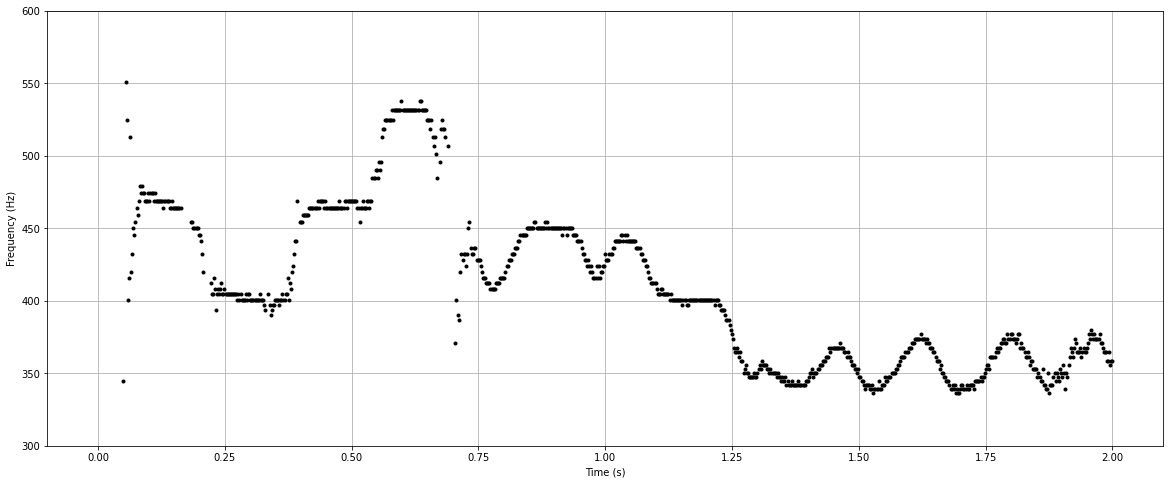

In [67]:
x_memo = np.linspace(0,2, num=len(pitches_memo))
plt.figure(figsize=(20,8))
plt.plot(x_memo,pitches_memo,'.k')
plt.grid()
plt.ylim(300,600)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [63]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 600 * 44100)
bounds = [ 20 , 600 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(detect_pitch(data, windows_size, i * windows_size, sample_rate, bounds))

100%|██████████| 289/289 [05:51<00:00,  1.22s/it]


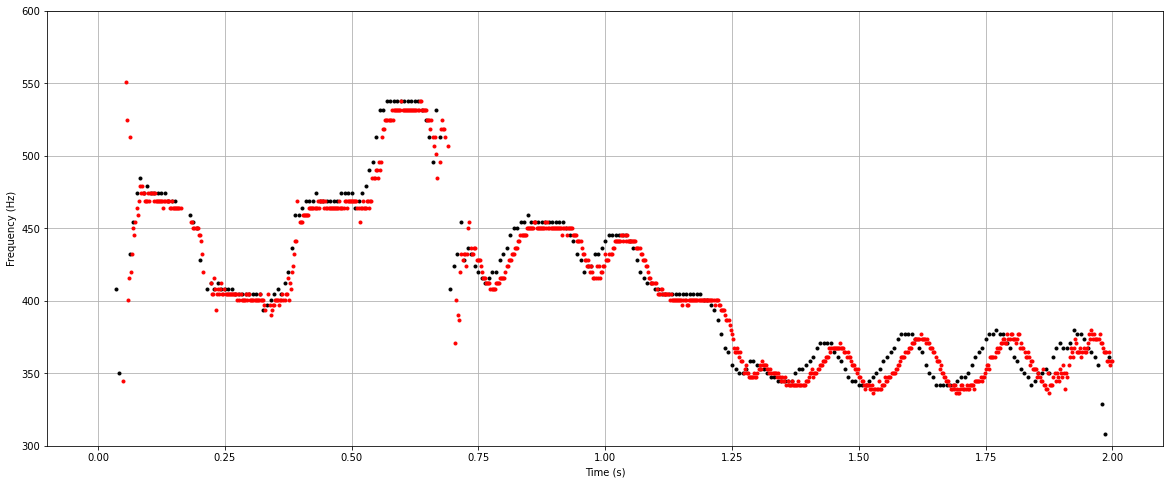

In [68]:
x = np.linspace(0, 2, num = len(pitches))
plt.figure(figsize=(20,8))
plt.plot(x,pitches,'.k')
plt.plot(x_memo,pitches_memo,'.r')
plt.grid()
plt.ylim(300,600)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()